# Embeddings und Vektordatenbanken

Embeddings sind zentral in Anwendungen von großen Sprachmodellen (large language models LLMs). Im Wesentlichen handelt es sich dabei um dichte Vektorrepräsentationen von Wörtern, die semantische Beziehungen erfassen.

#### Training und Funktion

Embeddings werden durch unüberwachtes Lernen an großen Textkorpora trainiert, wobei Wörter mit ähnlichen Bedeutungen im Vektorraum nah beieinander positioniert werden.

#### Nutzen

Wort-Embeddings verbessern das Sprachverständnis des Modells, indem sie Wissen über Beziehungen zwischen Wörtern liefern, was genauere Vorhersagen und kontextbewusstere Antworten ermöglicht. Diese Embeddings ermöglichen ein gewisses Maß an semantischem Verständnis.

In [1]:
import os

import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv  # zum laden von environment variablen
from langchain_openai import AzureOpenAIEmbeddings
from sklearn.metrics.pairwise import (
    cosine_similarity,  # zum vergleichen zweier Vektoren
)
load_dotenv()

True

Wir verwenden hier ein Embedding-Modell von OpenAI:

In [2]:
def get_embedder() -> AzureOpenAIEmbeddings:
    """Obtain an instance of the OpenAIEmbeddings class - a wrapper around the OpenAI API embedding functionality.

    Returns:
        OpenAIEmbeddings: an instance of the OpenAIEmbeddings class
    """
    return AzureOpenAIEmbeddings(model="text-embedding-3-small")


Ein häufig verwendetes Modell ist "text-embedding-ada-002", wir verwenden den Nachfolger "text-embedding-3":

In [3]:
embedder = get_embedder()

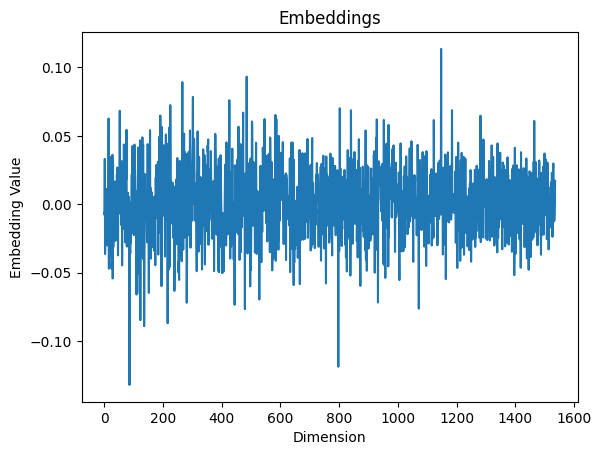

In [5]:
embeddings = embedder.embed_query("This is another test query")

sns.lineplot(x=range(len(embeddings)), y=embeddings)
plt.ylabel('Embedding Value')
plt.xlabel('Dimension')
plt.title('Embeddings')
plt.show()

Nun können wir beliebige Texte "embedden", und die Ähnlichkeit von zwei Texter via ihre embeddings vergleichen.

In [ ]:
embedding_1 = embedder.embed_query("Hallo")
embedding_2 = embedder.embed_query("hallo")

similarity_score = cosine_similarity([embedding_1], [embedding_2])[0, 0]

print(f"The similarity score is {similarity_score}")

The similarity score is 0.3567262259335675


## Aufgaben

1.1. Sehen Sie sich Embeddings anderer Eingaben an. Wie sehen diese aus? Welche Dinge sind tendenziell ähnlich/unähnlich? Können Sie längere Texte embedden, und macht das einen Unterschied? Können Sie andere Maße finden, die die Ähnlichkeit zwischen Embeddings bewerten?

1.2. Können Sie den obigen Code erweitern, um ein Embedding für verschiedene Textsorten zu erstellen und einen "maximal ähnlichen" Text für eine spezifische Texteingabe zu finden?

# Vector stores und Similarity search

Ein Vectorstore (oder Vektordatenbank) ist eine spezialisierte Datenbank, die darauf ausgelegt ist, semantische Suche von Texten mithilfe von Vektor-Embeddings zu ermöglichen.


In [14]:
from uuid import uuid4

from langchain_core.documents import Document
from langchain_core.vectorstores import InMemoryVectorStore

document_1 = Document(page_content="Alice likes pizza.", metadata={"page": 1})
document_2 = Document(page_content="Bob loves pasta.", metadata={"page": 2})
document_3 = Document(page_content="This is a test document.", metadata={"page": 1})
document_4 = Document(page_content="This is another test document.", metadata={"page": 1})

vectorstore = InMemoryVectorStore(embedding=get_embedder())

documents = [document_1, document_2, document_3, document_4]
ids = [str(uuid4()) for _ in range(len(documents))]
vectorstore.add_documents(documents=documents, ids=ids)

['14082e1c-9030-4610-86d9-bafd2d91e408',
 '86439b7f-e618-41a2-8d4d-2100afa764cf',
 'cef61e89-b453-4fd5-b1de-063b558c2748',
 'e87b58ae-9e5a-4eeb-8b68-a909957d48f1']

Wir können die Vektordatenbank nun in einen "retriever" (quasi eine Suchmaschine) umwandeln.

In [23]:
retriever = vectorstore.as_retriever(
    search_type="mmr",
    search_kwargs={"k": 4, "fetch_k": 4, "lambda_mult": 0.01, "score_threshold": 0.02},
)
retriever.invoke("bob")

[Document(id='86439b7f-e618-41a2-8d4d-2100afa764cf', metadata={'page': 2}, page_content='Bob loves pasta.'),
 Document(id='e87b58ae-9e5a-4eeb-8b68-a909957d48f1', metadata={'page': 1}, page_content='This is another test document.'),
 Document(id='14082e1c-9030-4610-86d9-bafd2d91e408', metadata={'page': 1}, page_content='Alice likes pizza.'),
 Document(id='cef61e89-b453-4fd5-b1de-063b558c2748', metadata={'page': 1}, page_content='This is a test document.')]

# Aufgaben

1.3. Welche Such-Parameter gibt es und was tun diese? Wie bekommen wir möglichst verschiedene Dokumente (in dem Fall, dass wir viele ähnliche Dokumente in der Datenbank haben)?

1.4. Wie können wir nur die relevantesten Dokumente erhalten?


# Ingest

Der "Ingest" Schritt bezeichnet das Laden und vorbereiten der "knowledge base" des RAG systems. Hierbei werden wir langchain Funktionen verwenden um ein oder meherere PDFs einzulesen, aufzuspalten und zusammein mit ihren embeddings in eine Vektordatenbank zu speichen.

## Aufgabe

1.5. Laden das angegebene PDF in eine Vektordatenbank.
1.6. Teste die Suche mit der Vektordatenbank. Schaue dafür in das PDF und gib einen Suchbegriff ein.

In [33]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter

pdf_loader = PyPDFLoader("../data/Broschure-Sortiment-MicroFluidics.pdf")
# TODO: Lade das PDF-Dokument und weise es der Variable pdf_pages zu.
pdf_pages = pdf_loader.load_and_split(text_splitter=RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100))

In [34]:
page=3
print(f'Content: \n {pdf_pages[page].page_content}')
print('##########')
print(f'Source: \n {pdf_pages[page].metadata["source"]}')
print('##########')
print(f'Page: \n {pdf_pages[page].metadata["page"]}')

Content: 
 Ihre MicroFluidics und Bürkert: 
die richtige Entscheidung.  
In der Mess-, Steuer- und Regelungstechnik ist Bürkert 
weltweit führend. Im Bereich der MicroFluidics ist uns 
keine Ihrer Herausforderungen zu groß oder klein. 
Gewachsenes Know-how in der Labor- und Medizin-
technik kombinieren wir mit der Innovationskraft unserer 
mehr als hundert Entwicklerinnen und Entwickler und 
einer enormen Fertigungstiefe. 
Im Ergebnis realisieren wir genau die Lösung, die Ihre
##########
Source: 
 ../data/Broschure-Sortiment-MicroFluidics.pdf
##########
Page: 
 2


In [35]:
page=3
print(f'Content: \n {pdf_pages[page].page_content}')
print('##########')
print(f'Source: \n {pdf_pages[page].metadata["source"]}')
print('##########')
print(f'Page: \n {pdf_pages[page].metadata["page"]}')

Content: 
 einer enormen Fertigungstiefe. 
Im Ergebnis realisieren wir genau die Lösung, die Ihre 
individuelle Herausforderung perfekt meistert. Mit kurzen 
Entwicklungszyklen, als komplett geprüftes System,  
exakt passend für Ihr Gerät. Darauf können Sie sich 
absolut verlassen – und Ihre Energie und Kapazitäten  
auf das Wesentliche konzentrieren: Ihr Business.
##########
Source: 
 ../data/Broschure-Sortiment-MicroFluidics.pdf
##########
Page: 
 2
